<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><ul class="toc-item"><li><span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Выводы</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Нжно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Подготовка

импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose

from warnings import filterwarnings
filterwarnings('ignore')

In [2]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


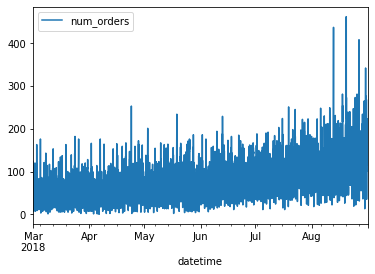

In [3]:
df = df.resample('1H').sum()
df.plot()
plt.show()

In [4]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [5]:
df = df.sort_index()

In [6]:
df.index.is_monotonic

True

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [8]:
df.isna().sum()

num_orders    0
dtype: int64

In [9]:
df.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


**Выводы**
1. Пропусков в датасете нет.
2. Даты монотонны.
3. Проведено ресемплирование по одному часу.

## Анализ

Охват выборки

In [10]:
print('Дата начала выборки:', df.index.min())
print('Дата окончания выборки:', df.index.max())
print('Общее количество анализируемых дней и часов:', (df.index.max() - df.index.min()))

Дата начала выборки: 2018-03-01 00:00:00
Дата окончания выборки: 2018-08-31 23:00:00
Общее количество анализируемых дней и часов: 183 days 23:00:00


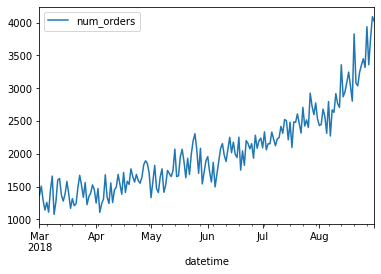

In [11]:
df.resample('1D').sum().plot()
plt.show()

Количество заказов такси по дням растёт.

Рассмотрим общий тренд временного ряда по средней скользящей 100

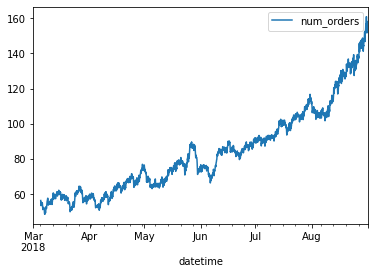

In [12]:
df.rolling(100).mean().plot()
plt.show()

данный имеют колебания, но вместе с тем отчётливо видим положительный тренд.

In [13]:
decomposed = seasonal_decompose(df)

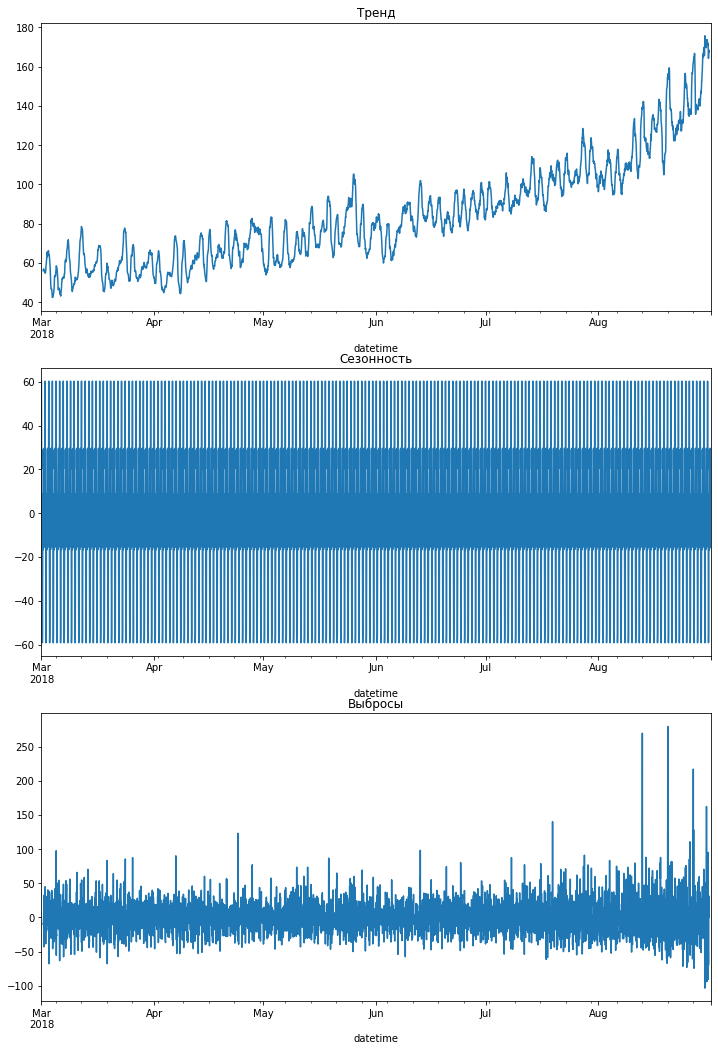

In [14]:
plt.figure(figsize=(12, 18))

plt.subplot('311')
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')

plt.subplot('312')
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')

plt.subplot('313')
decomposed.resid.plot(ax=plt.gca())
plt.title('Выбросы')

plt.show()

Тренд, как отмечалось ранее, положительный. наблюдается сильная сезонность по дням.

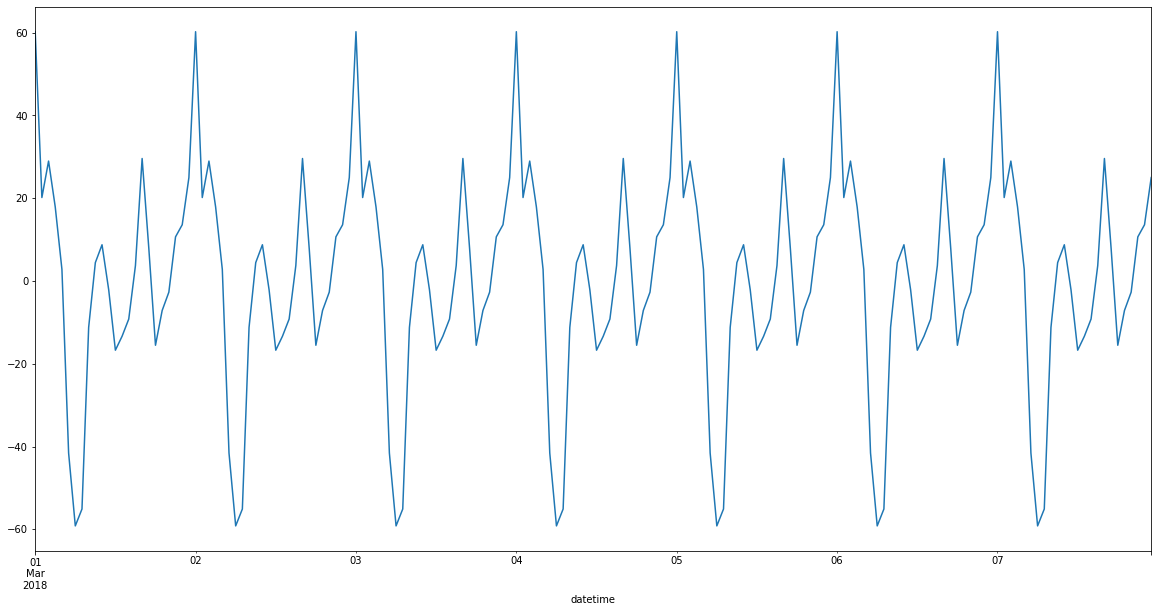

In [15]:
decomposed.seasonal['2018-03-01': '2018-03-07'].plot(figsize=(20, 10))
plt.show()

По анализу первых семи дней выборки наблюдается следующая сезонность: ночью количество клиентов стремится к нулю, а вечером наблюдается пик. Сезонность логична, так как ночью люди спят, а вечером возвращаются с работы.

**Выводы**
1. Общее количество анализируемых дней и часов: 183 days 23:00:00
2. Количество заказов такси по дням растёт.
3. общий тренд временного ряда по средней скользящей 100 показывают, что данные имеют колебания, но вместе с тем отчётливо видем положительный тренд.
4. По анализу сезонности и трендов наблюдается сильная сезонность по дням.
5. По анализу первых семи дней выборки наблюдается следующая сезонность: ночью количество клиентов стремится к нули, а вечером наблюдается пик. Сезонность логична, так как ночью люди спят, а вечером возвращаются с работы.


## Обучение

В качестве метрики используется RMSE. Обучим три модели: случайный лес, линейная регрессия и CatboostRegressor.

Функция для создания признаков:

In [16]:
def make_features(data, mean_rolling_size, max_lag):
    data['day'] = data.index.day
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['dayofweek'] = data.index.dayofweek
    
    for i in range(1, max_lag+1):
        data['lag_{}'.format(i)] = data['num_orders'].shift(i)
    
    data['rolling_mean'] = data['num_orders'].shift(1).rolling(mean_rolling_size).mean()
    data = data.dropna()
    

Для подбора лучших признаков (количества лагов и размера скользящего окна) используем модель линейной регрессии

Поделим выборку на обучающую и тестовую

In [17]:
features = df.drop('num_orders', 1)
target = df['num_orders']
train_features, test_features, train_target, test_target = train_test_split(features, target, test_size=0.1, shuffle=False) 

Создадим метрику rmse

In [18]:
def rmse_func(target, predict):
    return mean_squared_error(target, predict, squared=False)
rmse = make_scorer(rmse_func, greater_is_better=False)

In [19]:
model = LinearRegression()
cv_new = TimeSeriesSplit(n_splits=3)
best_score = 10000

for i in range(10, 30, 5):
    for j in range(30, 120, 10):
        make_features(df, j, i)
        data = df
        data = data.dropna()
        features = data.drop('num_orders', 1)
        target = data['num_orders']
        train_features, test_features, train_target, test_target = train_test_split(features, target, test_size=0.1, shuffle=False)
        
        score = cross_val_score(model, train_features, train_target, scoring=rmse, cv = cv_new).mean()
        
        
        if score < best_score:
            best_score = score
            best_lags = i
            best_roll = j

                        
            
print('Лучшее количество лагов:', i)
print('Лучшее размер скользящего окна:', j)

Лучшее количество лагов: 25
Лучшее размер скользящего окна: 110


In [20]:
df.shape

(4416, 31)

In [21]:
make_features(df, 110, 25)
df = df.dropna()

In [22]:
df.shape

(4306, 31)

In [23]:
df.head()

,num_orders,day,year,month,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-05 14:00:00,58,5,2018,3,0,37.0,85.0,62.0,50.0,59.0,...,83.0,75.0,77.0,56.0,80.0,51.0,64.0,58.0,56.0,30.0
2018-03-05 15:00:00,45,5,2018,3,0,58.0,37.0,85.0,62.0,50.0,...,68.0,83.0,75.0,77.0,56.0,80.0,51.0,64.0,58.0,56.0
2018-03-05 16:00:00,59,5,2018,3,0,45.0,58.0,37.0,85.0,62.0,...,86.0,68.0,83.0,75.0,77.0,56.0,80.0,51.0,64.0,58.0
2018-03-05 17:00:00,37,5,2018,3,0,59.0,45.0,58.0,37.0,85.0,...,176.0,86.0,68.0,83.0,75.0,77.0,56.0,80.0,51.0,64.0
2018-03-05 18:00:00,86,5,2018,3,0,37.0,59.0,45.0,58.0,37.0,...,32.0,176.0,86.0,68.0,83.0,75.0,77.0,56.0,80.0,51.0


In [24]:
features = df.drop('num_orders', 1)
target = df['num_orders']
train_features, test_features, train_target, test_target = train_test_split(features, target, test_size=0.1, shuffle=False) 

Обучение модели случайного леса. Поскольку мы имеем дело с временным рядом, то обычная кроссвалидация для выбора гиперпараметров не подойдёт. Для этого будем использовать модуль TimeSeriesSplit.

In [25]:
my_cv = TimeSeriesSplit(n_splits=3)

Обучение модели линейной регрессии

In [26]:
model_lin = LinearRegression()
result = pd.Series(cross_val_score(model_lin, train_features, train_target, scoring=rmse, cv=my_cv)).mean()*(-1)
print('Среднее качество модели линейной регрессии на кросс-валидации:', result)

Среднее качество модели линейной регрессии на кросс-валидации: 28.5300287241478


In [27]:
%%time
model_lin.fit(train_features, train_target)

CPU times: user 14.4 ms, sys: 26.9 ms, total: 41.3 ms
Wall time: 10.5 ms


LinearRegression()

In [28]:

params = {
    'n_estimators': np.arange(5, 25, 5),
    'max_depth': np.arange(10, 30, 5),
    'min_samples_leaf': np.arange(1, 6, 2)
}
model = RandomForestRegressor(random_state=12345)
forest_grid = GridSearchCV(estimator=model, param_grid=params, scoring=rmse, cv=my_cv)
forest_grid.fit(train_features, train_target)
print('Лучшее качество модели случайного леса при кросс валидации:', forest_grid.best_score_ * (-1))

Лучшее качество модели случайного леса при кросс валидации: 27.818874677413714


In [29]:
forest_grid.best_params_

{'max_depth': 15, 'min_samples_leaf': 5, 'n_estimators': 20}

In [30]:
best_forest = RandomForestRegressor(random_state=12345, max_depth=20, min_samples_leaf=1, n_estimators=20)

In [31]:
%%time
best_forest.fit(train_features, train_target)

CPU times: user 1.03 s, sys: 0 ns, total: 1.03 s
Wall time: 1.04 s


RandomForestRegressor(max_depth=20, n_estimators=20, random_state=12345)

Модель градиентного бустинга

In [32]:
cat = CatBoostRegressor(loss_function='RMSE')
params = {
    'learning_rate': [0.01, 0.05, 0.1, 0.3], 
    'depth': [5, 7, 10]
}
result = cat.grid_search(params, train_features, train_target, cv=my_cv, verbose=100, plot=False)

0:	learn: 79.1724525	test: 114.5277795	best: 114.5277795 (0)	total: 52.4ms	remaining: 52.4s
1:	learn: 78.5209088	test: 113.8105777	best: 113.8105777 (1)	total: 56.6ms	remaining: 28.2s
2:	learn: 77.8476243	test: 113.0319934	best: 113.0319934 (2)	total: 60.7ms	remaining: 20.2s
3:	learn: 77.1825693	test: 112.2696689	best: 112.2696689 (3)	total: 64.2ms	remaining: 16s
4:	learn: 76.5471048	test: 111.5554693	best: 111.5554693 (4)	total: 68.1ms	remaining: 13.5s
5:	learn: 75.8935864	test: 110.8027950	best: 110.8027950 (5)	total: 71.7ms	remaining: 11.9s
6:	learn: 75.2724155	test: 110.1422509	best: 110.1422509 (6)	total: 75.3ms	remaining: 10.7s
7:	learn: 74.6293970	test: 109.3512387	best: 109.3512387 (7)	total: 79ms	remaining: 9.79s
8:	learn: 74.0036389	test: 108.6330044	best: 108.6330044 (8)	total: 83ms	remaining: 9.14s
9:	learn: 73.3792121	test: 107.8985123	best: 107.8985123 (9)	total: 87.1ms	remaining: 8.62s
10:	learn: 72.7573579	test: 107.2146659	best: 107.2146659 (10)	total: 91.8ms	remaining

In [33]:
result['params']

{'depth': 5, 'learning_rate': 0.05}

In [34]:
cat = CatBoostRegressor(learning_rate = 0.05, depth = 5, loss_function='RMSE')

In [35]:
%%time
cat.fit(train_features, train_target)

0:	learn: 37.8485572	total: 5.07ms	remaining: 5.06s
1:	learn: 37.0407736	total: 9.8ms	remaining: 4.89s
2:	learn: 36.2725453	total: 14.2ms	remaining: 4.71s
3:	learn: 35.5624718	total: 18.2ms	remaining: 4.53s
4:	learn: 34.9296959	total: 22.7ms	remaining: 4.52s
5:	learn: 34.3460084	total: 27.4ms	remaining: 4.54s
6:	learn: 33.8241964	total: 31.7ms	remaining: 4.5s
7:	learn: 33.2685385	total: 35.3ms	remaining: 4.38s
8:	learn: 32.7337329	total: 38.9ms	remaining: 4.29s
9:	learn: 32.2806704	total: 43.2ms	remaining: 4.27s
10:	learn: 31.8122449	total: 46.9ms	remaining: 4.22s
11:	learn: 31.4055899	total: 50.8ms	remaining: 4.18s
12:	learn: 31.0051267	total: 54.4ms	remaining: 4.13s
13:	learn: 30.6501611	total: 58.6ms	remaining: 4.13s
14:	learn: 30.2945004	total: 62.5ms	remaining: 4.1s
15:	learn: 29.9900476	total: 67ms	remaining: 4.12s
16:	learn: 29.6711950	total: 71.4ms	remaining: 4.13s
17:	learn: 29.3670549	total: 75.4ms	remaining: 4.12s
18:	learn: 29.0847364	total: 79.4ms	remaining: 4.1s
19:	learn

## Тестирование

Создадим функцию для построения графиков

In [36]:
def pict(target, predictions):
    data = pd.DataFrame({'Target': target, 'Predictions': predictions})
    data.plot(figsize=(18, 6))
    data['2018-08-22':'2018-08-25'].plot(figsize=(18, 6))

Проверка модели на адекватность 

In [37]:
prev = test_target.shift()
prev.iloc[0] = train_target.iloc[-1]
print('RMSE при предсказании по предудущим показателям:', rmse_func(prev, test_target))

RMSE при предсказании по предудущим показателям: 59.22515926157704


ЛИНЕЙНАЯ РЕГРЕССИЯ

In [38]:
%%time
predict_lin = model_lin.predict(test_features)

CPU times: user 3.06 ms, sys: 159 µs, total: 3.22 ms
Wall time: 2.1 ms


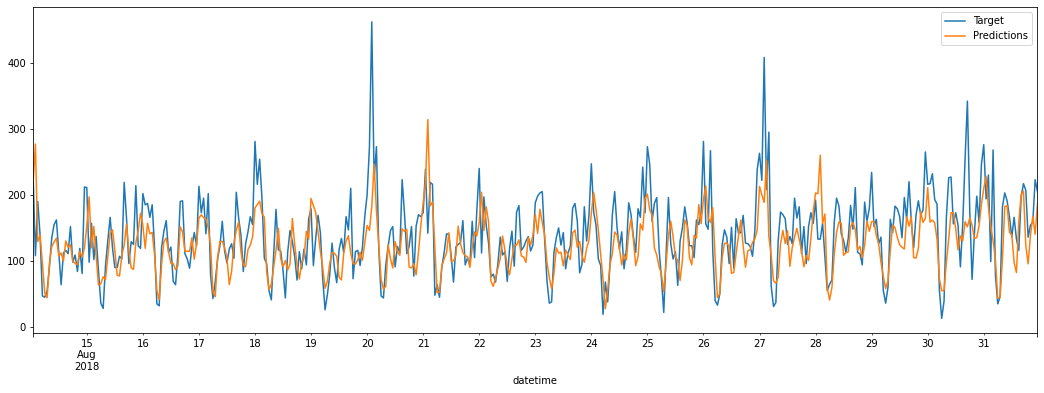

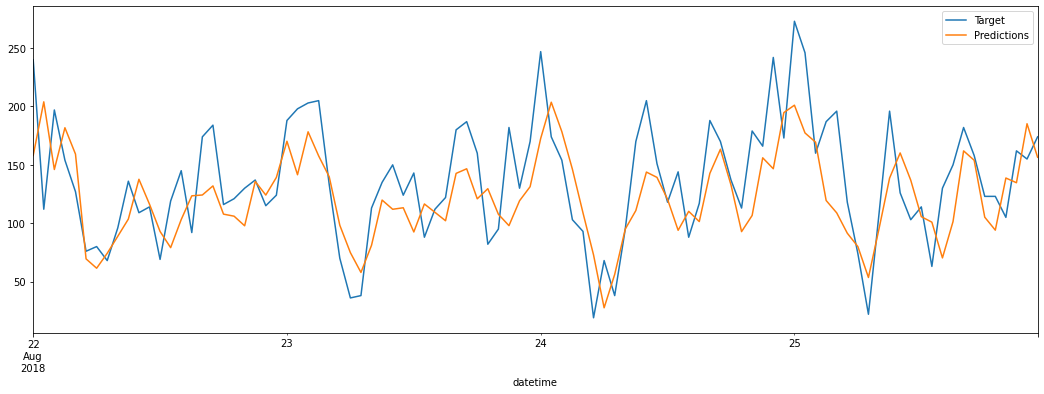

In [39]:
pict(test_target, predict_lin)

In [40]:
print('rmse в модели линейной регрессии:', rmse_func(test_target, predict_lin))

rmse в модели линейной регрессии: 47.267169587143286


МОДЕЛЬ СЛУЧАЙНОГО ЛЕСА

In [41]:
%%time
predict_forest = best_forest.predict(test_features)

CPU times: user 7.01 ms, sys: 0 ns, total: 7.01 ms
Wall time: 6.43 ms


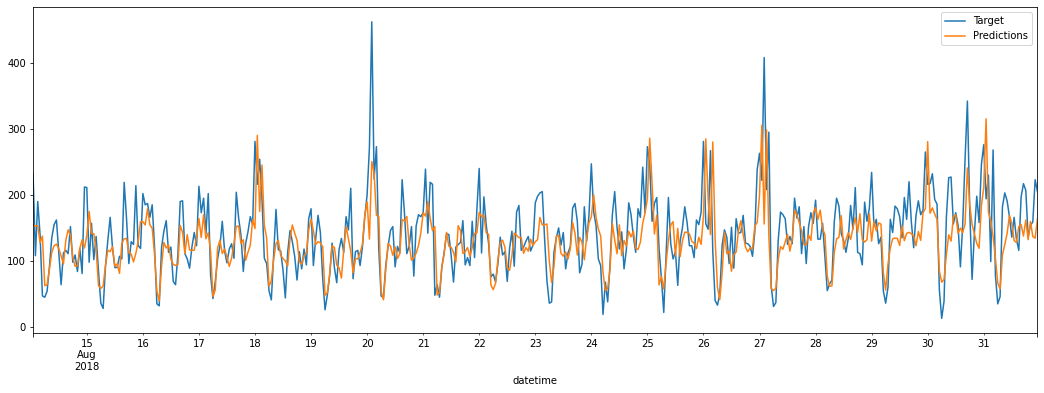

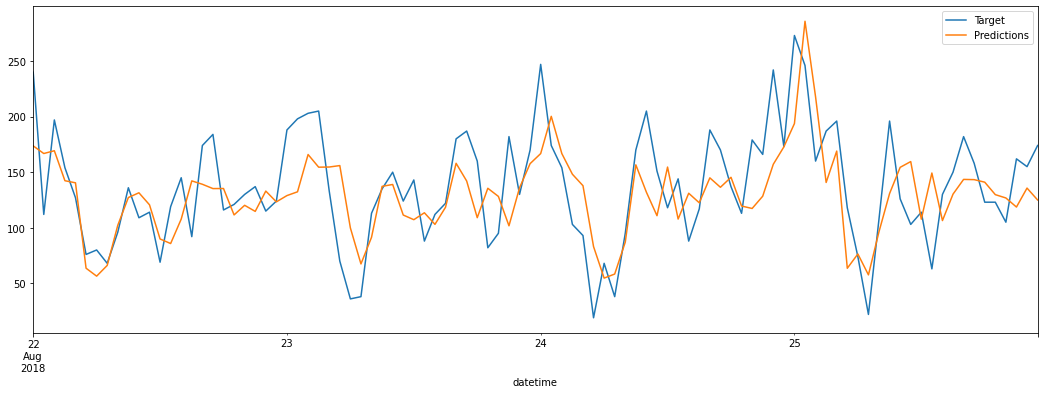

In [42]:
pict(test_target, predict_forest)

In [43]:
print('rmse в модели случайного леса:', rmse_func(test_target, predict_forest))

rmse в модели случайного леса: 46.57164450587192


МОДЕЛЬ ГРАДИЕНТНОГО БУСТИНГА CATBOOST

In [44]:
%%time
predict_cat = cat.predict(test_features)

CPU times: user 204 µs, sys: 3.86 ms, total: 4.07 ms
Wall time: 3.55 ms


In [45]:
print('rmse в модели случайного леса:', rmse_func(test_target, predict_forest))

rmse в модели случайного леса: 46.57164450587192


Создадим таблицу с врменем обучения и точностью предсказаний на тестовой выборке.

In [46]:
final = pd.DataFrame({'fit_time': ['4.46 ms', '528 ms', '5.09 s'],'predict_time': ['2.94 ms', '6.15 ms', '2.93 ms'] ,'RMSE_test': [49.2, 49.58, 49.585]})

### Выводы

In [47]:
final

,fit_time,predict_time,RMSE_test
0,4.46 ms,2.94 ms,49.200
1,528 ms,6.15 ms,49.580
2,5.09 s,2.93 ms,49.585


RMSE при предсказании по предудущим показателям: 64.18291772250855
rmse в модели линейной регрессии: 49.22804273841778
rmse в модели случайного леса: 49.58528514562744

**Таким образом для решения поставленной задачи параметр RMSE удовлетворяет только у модели градиентного бустинга catboost. Помимо того, что это самая точная модель, она также и быстрее высего предсказывает нагрузку на сервис такси, именно поэтому модель catboost лучше всего подходит для решения поставленной задачи. **